<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Build-a-test-circuit" data-toc-modified-id="Build-a-test-circuit-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build a test circuit</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Use-qiskit-to-check-how-it-looks" data-toc-modified-id="Use-qiskit-to-check-how-it-looks-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Use qiskit to check how it looks</a></span></li><li><span><a href="#Draw-line-graph" data-toc-modified-id="Draw-line-graph-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Draw line graph</a></span></li></ul></li><li><span><a href="#Get-a-test-amplitude" data-toc-modified-id="Get-a-test-amplitude-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get a test amplitude</a></span></li></ul></li><li><span><a href="#Perform-fsim-decomposition" data-toc-modified-id="Perform-fsim-decomposition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Perform fsim decomposition</a></span></li><li><span><a href="#Use-sycamore" data-toc-modified-id="Use-sycamore-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Use sycamore</a></span></li></ul></div>

In [696]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import qiskit

from qtensor import QtreeBuilder, QiskitBuilder
from qtensor.optimisation.TensorNet import QtreeTensorNet

In [697]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build a test circuit

In [859]:
def build_test_circuit(builder):
    layers  = builder.n_qubits // 2
    for _ in range(layers):
        for q in builder.qubits:
            builder.apply_gate(builder.operators.H, q)

        for q1, q2 in zip(builder.qubits[1::2], builder.qubits[::2]):
            builder.apply_gate(builder.operators.fSim, q1, q2, alpha=.3, beta=.2)

        for q in builder.qubits:
            builder.apply_gate(builder.operators.H, q)

        for q1, q2 in zip(builder.qubits[2::2], builder.qubits[1::2]):
            builder.apply_gate(builder.operators.fSim, q1, q2, alpha=.3, beta=.2)
        
        if not builder.n_qubits % 2:
            q1, q2 = builder.qubits[0], builder.qubits[-1]
            builder.apply_gate(builder.operators.fSim, q1, q2, alpha=.3, beta=.2)
       

In [860]:
N = 9

#### Use qiskit to check how it looks

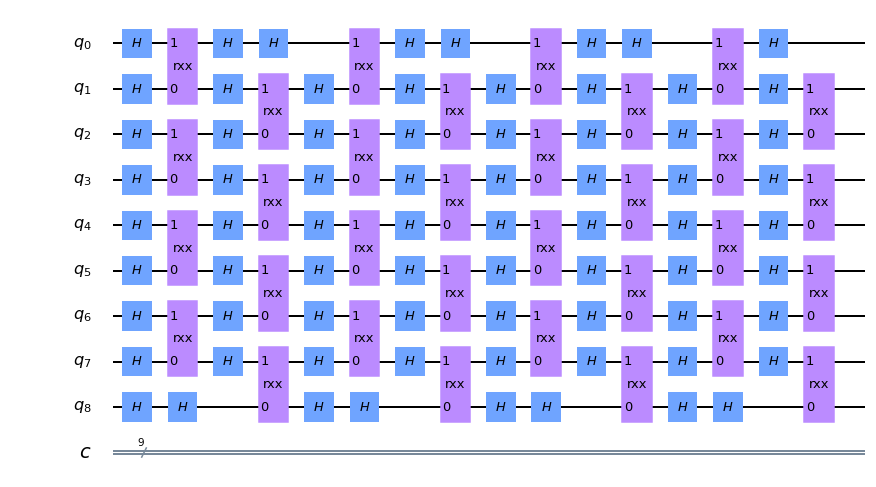

In [861]:
qsbuilder = QiskitBuilder(N)
qsbuilder.operators.fSim = lambda *qs,**_: qiskit.extensions.standard.RXXGate(*qs, theta=.7)

build_test_circuit(qsbuilder)
qsbuilder.circuit.draw('mpl')

In [862]:
builder = QtreeBuilder(N)
build_test_circuit(builder)
tn = QtreeTensorNet.from_qtree_gates(builder.circuit)
line_graph = tn.get_line_graph(ignore_inputs=False)

In [863]:
builder.circuit

[H(0),
 H(1),
 H(2),
 H(3),
 H(4),
 H(5),
 H(6),
 H(7),
 H(8),
 fSim[alpha=0.30,beta=0.20](1,0),
 fSim[alpha=0.30,beta=0.20](3,2),
 fSim[alpha=0.30,beta=0.20](5,4),
 fSim[alpha=0.30,beta=0.20](7,6),
 H(0),
 H(1),
 H(2),
 H(3),
 H(4),
 H(5),
 H(6),
 H(7),
 H(8),
 fSim[alpha=0.30,beta=0.20](2,1),
 fSim[alpha=0.30,beta=0.20](4,3),
 fSim[alpha=0.30,beta=0.20](6,5),
 fSim[alpha=0.30,beta=0.20](8,7),
 H(0),
 H(1),
 H(2),
 H(3),
 H(4),
 H(5),
 H(6),
 H(7),
 H(8),
 fSim[alpha=0.30,beta=0.20](1,0),
 fSim[alpha=0.30,beta=0.20](3,2),
 fSim[alpha=0.30,beta=0.20](5,4),
 fSim[alpha=0.30,beta=0.20](7,6),
 H(0),
 H(1),
 H(2),
 H(3),
 H(4),
 H(5),
 H(6),
 H(7),
 H(8),
 fSim[alpha=0.30,beta=0.20](2,1),
 fSim[alpha=0.30,beta=0.20](4,3),
 fSim[alpha=0.30,beta=0.20](6,5),
 fSim[alpha=0.30,beta=0.20](8,7),
 H(0),
 H(1),
 H(2),
 H(3),
 H(4),
 H(5),
 H(6),
 H(7),
 H(8),
 fSim[alpha=0.30,beta=0.20](1,0),
 fSim[alpha=0.30,beta=0.20](3,2),
 fSim[alpha=0.30,beta=0.20](5,4),
 fSim[alpha=0.30,beta=0.20](7,6),
 H(0)

#### Draw line graph

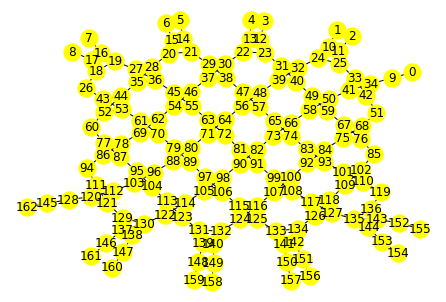

In [864]:
nx.draw_kamada_kawai(line_graph, with_labels=True, node_color='yellow')

In [865]:
import qtensor

In [866]:
opt = qtensor.optimisation.Optimizer.DefaultOptimizer()
peo, tn = opt.optimize(tn)
print('contraction width', opt.treewidth)

contraction width 10


### Get a test amplitude

In [867]:
sim = qtensor.Simulate.QtreeSimulator()
state = sim.simulate_batch(builder.circuit, batch_vars=N)
print('First amplitudes of state:\n', state[:5])


First amplitudes of state:
 [-0.63017219+0.039351j   -0.08556286-0.02501223j  0.01799542-0.08076869j
 -0.00690132+0.02476996j -0.05426098-0.14516016j]


## Perform fsim decomposition


In [868]:
import qtree

In [869]:
import itertools

In [870]:
def fsim_replacer(fsim_tensor, fsim_data, graph, neighbouring_tensors):
    """
    Format of 2-d matrix with multiindices
    F = 
          cd 
        (1  5  )
     a  ( 26   )
     b  ( 73   )
        (8  4  )
        
    a, b are outputs
    c, d are inputs
    
    mappnig to new indices ijk
    
    i = a
    j = b
    k = a^c
    
    G = [
        [[1,2],[3,4]], k = 0
        [[5,6],[7,8]]  k = 1
    ]
    K_cak = [
        [[1,0],[0,1]], k = 0
        [[0,1],[1,0]]  k = 1
    ]
    
    F_abcd = K_kca*G_kab*K_kbd

    """
    
    F = fsim_data.swapaxes(1,2)
    Fsq = F.reshape(4, 4)
    diag0 = np.diag(Fsq)
    diag1 = np.diag(np.fliplr(Fsq))
    G = np.array([diag0, diag1]).reshape(2,2,2)
    
    a, c, b, d = fsim_tensor.indices
    #                                  FIXME
    i, j, k = a, b, qtree.optimizer.Var(1000+(b), size=2)
    
    K = np.array([np.eye(2), np.fliplr(np.eye(2))])
    k_key = 'K'+fsim_tensor.name
    g_key = 'G'+fsim_tensor.name
    tensor_k = qtree.optimizer.Tensor(k_key, [k, a, c], data_key=k_key)
    tensor_k2 = qtree.optimizer.Tensor(k_key, [k, b, d], data_key=k_key)
    tensor_g = qtree.optimizer.Tensor(g_key, [k, a, b], data_key=g_key)
    
    tensors_to_add = [tensor_k, tensor_g, tensor_k2]
    add_data_dict = {k_key: K, g_key: G}
    return tensors_to_add, add_data_dict

def decompose_fsims(tn):
    tensors = sum(tn.buckets, [])
    graph = tn.get_line_graph(ignore_inputs=False)
    id_to_tenosrs = {t['indices']: t for *edge, t in graph.edges(data='tensor')}
    tensors_uq = [qtree.optimizer.Tensor(**t) for t in id_to_tenosrs.values() ]
    names = [t.name for t in tensors_uq]
    while 'fSim' in names:
        for tensor in tensors_uq:
            if 'fSim' == tensor.name:
                fsim_tensor = tensor
                neighbouring_tensors = []
                edges_to_remove = []
                for edgedata in graph.edges(data='tensor', nbunch=list(map(int, fsim_tensor.indices))):
                    *edge, tensorn = edgedata
                    if tensorn['indices'] == tuple(map(int, fsim_tensor.indices)):
                        edges_to_remove.append(edge)

                    neighbouring_tensors.append(tensorn)
                #neighbouring_tensors = list( set(neighbouring_tensors) - set([fsim_tensor]))
                fsim_data = tn.data_dict[fsim_tensor.data_key]
                tensors_to_add, add_data_dict = fsim_replacer(fsim_tensor, fsim_data, graph, neighbouring_tensors)
                tn.data_dict.update(add_data_dict)

                for u, v in edges_to_remove:
                    graph.remove_edge(u, v)

                # add new tensors to graph
                for tensor in tensors_to_add:
                    new_nodes = []
                    for idx in tensor.indices:
                        graph.add_node(int(idx), name='k_'+str(idx), size=2)
                        new_nodes.append(int(idx))
                    if len(new_nodes) > 1:
                        edges = itertools.combinations(new_nodes, 2)
                    else:
                        node = new_nodes[0]
                        edges = [[node, node]]

                    graph.add_edges_from(
                        edges,
                        tensor={'name': tensor.name
                                ,'indices':tuple(map(int, tensor.indices))
                                ,'data_key': tensor.data_key
                               }
                    )
                    
                id_to_tenosrs = {t['indices']: t for *edge, t in graph.edges(data='tensor')}
                tensors_uq = [qtree.optimizer.Tensor(**t) for t in id_to_tenosrs.values() ]
                names = [t.name for t in tensors_uq]
                break

    buckets = qtree.optimizer.graph2buckets(graph)
    tensors = sum(buckets, [])
    # print('tensors', tensors)
    return qtensor.optimisation.TensorNet.QtreeTensorNet(buckets, tn.data_dict, tn.bra_vars, tn.ket_vars)
    

In [871]:
tn = QtreeTensorNet.from_qtree_gates(builder.circuit)

In [872]:
opt = qtensor.optimisation.Optimizer.TamakiOptimizer(wait_time=40)
peo, _ = opt.optimize(tn2)

print('contrcation w/ tamaki', opt.treewidth)

opt = qtensor.optimisation.Optimizer.DefaultOptimizer()

contrcation w/ tamaki 5


contraction width 10


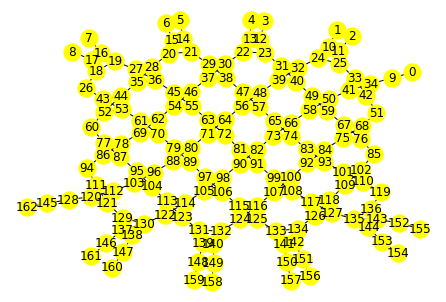

In [873]:
line_graph = tn.get_line_graph(ignore_inputs=False)
nx.draw_kamada_kawai(line_graph, with_labels=True, node_color='yellow')
peo, tn = opt.optimize(tn)
print('contraction width', opt.treewidth)

In [874]:
tn.buckets = qtree.optimizer.graph2buckets(line_graph)
sim = qtensor.Simulate.QtreeSimulator()
state = sim.simulate_batch(builder.circuit, batch_vars=N)


sim.tn = tn
sim._set_free_qubits(range(N))
#sim._set_free_qubits([])
opt = qtensor.optimisation.Optimizer.DefaultOptimizer()
peo, tn = opt.optimize(tn)
sim.tn = tn
sim.peo = peo
sim._reorder_buckets()

slice_dict = sim._get_slice_dict()
sliced_buckets = tn.slice(slice_dict)

print('peo', sim.peo)
result = qtree.optimizer.bucket_elimination(
    sliced_buckets,
    sim.bucket_backend.process_bucket,
    n_var_nosum=len(sim.tn.free_vars)
)
result.data.flatten()[:5]

peo [i_0, i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, v_145, v_128, v_147, v_146, v_151, v_150, v_153, v_152, v_149, v_148, v_139, v_140, v_131, v_132, v_26, v_60, v_119, v_143, v_144, v_136, v_135, v_51, v_9, v_85, v_141, v_142, v_133, v_134, v_137, v_138, v_130, v_94, v_120, v_111, v_112, v_121, v_129, v_125, v_88, v_89, v_105, v_106, v_58, v_59, v_75, v_76, v_10, v_11, v_24, v_25, v_34, v_41, v_42, v_92, v_93, v_109, v_110, v_118, v_127, v_90, v_91, v_107, v_108, v_52, v_53, v_69, v_70, v_16, v_17, v_18, v_19, v_35, v_36, v_56, v_57, v_73, v_74, v_54, v_55, v_71, v_72, v_12, v_13, v_22, v_23, v_39, v_40, v_14, v_15, v_20, v_21, v_37, v_38, v_123, v_104, v_87, v_86, v_95, v_103, v_113, v_122, v_29, v_31, v_63, v_65, v_27, v_61, v_99, v_101, v_33, v_67, v_97, v_124, v_96, v_114, v_115, v_50, v_68, v_100, v_117, v_43, v_44, v_77, v_78, v_79, v_64, v_98, v_116, v_126, v_45, v_62, v_81, v_80, v_82, v_83, v_30, v_28, v_47, v_46, v_48, v_32, v_49, v_66, v_84, v_102, o_0, o_1, o_2, o_3, o_4, o_

array([-0.63017219+0.039351j  , -0.08556286-0.02501223j,
        0.01799542-0.08076869j, -0.00690132+0.02476996j,
       -0.05426098-0.14516016j])

In [875]:
tn = QtreeTensorNet.from_qtree_gates(builder.circuit)

In [876]:
tn2 = decompose_fsims(tn)


In [877]:
opt = qtensor.optimisation.Optimizer.TamakiOptimizer(wait_time=40)
peo, _ = opt.optimize(tn2)

print('contrcation w', opt.treewidth)

contrcation w 7


In [878]:
opt = qtensor.optimisation.Optimizer.DefaultOptimizer()

contraction width 10


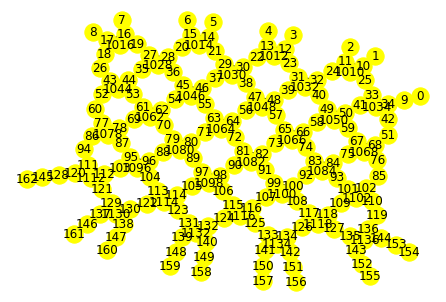

In [879]:
line_graph = tn2.get_line_graph(ignore_inputs=False)
nx.draw_kamada_kawai(line_graph, with_labels=True, node_color='yellow')
peo, _ = opt.optimize(tn2)
print('contraction width', opt.treewidth)

In [880]:
tn2.buckets = qtree.optimizer.graph2buckets(line_graph)

sim = qtensor.Simulate.QtreeSimulator()

sim.tn = tn2
sim._set_free_qubits(range(N))
#sim._set_free_qubits([])
opt = qtensor.optimisation.Optimizer.DefaultOptimizer()
peo, tn2 = opt.optimize(tn2)
sim.tn = tn2
sim.peo = peo
sim._reorder_buckets()


slice_dict = sim._get_slice_dict()
sliced_buckets = tn2.slice(slice_dict)

print('tw', opt.treewidth)
print('peo', sim.peo)
result = qtree.optimizer.bucket_elimination(
    sliced_buckets,
    sim.bucket_backend.process_bucket,
    n_var_nosum=len(sim.tn.free_vars)
)
result.data.flatten()[:5]

tw 14
peo [i_0, i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, v_145, v_128, v_147, v_146, v_149, v_148, v_153, v_152, v_151, v_150, v_9, k_141, k_142, k_v_1134, k_133, k_134, v_85, v_51, v_119, k_143, k_144, k_v_1136, k_136, k_135, v_60, v_26, k_139, k_140, k_v_1132, k_131, k_132, v_94, k_137, k_138, k_v_1130, k_129, k_130, k_120, k_v_1112, k_121, k_86, k_87, k_103, k_104, k_123, k_20, k_21, k_37, k_38, k_22, k_23, k_39, k_40, k_54, k_55, k_71, k_72, k_56, k_57, k_73, k_74, k_18, k_19, k_35, k_36, k_52, k_53, k_69, k_70, k_90, k_91, k_107, k_108, k_109, k_110, k_92, k_93, k_24, k_25, k_41, k_42, k_58, k_59, k_75, k_76, k_88, k_89, k_105, k_106, k_125, k_v_1116, k_v_1098, k_v_1080, k_v_1068, k_v_1050, k_34, k_v_1034, k_10, k_v_1010, k_11, k_v_1084, k_v_1118, k_v_1102, k_118, k_127, k_v_1100, k_v_1082, k_v_1062, k_v_1044, k_v_1028, k_16, k_v_1016, k_17, k_v_1066, k_v_1048, k_v_1064, k_v_1046, k_v_1032, k_12, k_v_1012, k_13, k_v_1030, k_14, k_v_1014, k_15, k_v_1114, k_v_1096, k_v_1078, k_111, k

array([-0.63017219+0.039351j  , -0.08556286-0.02501223j,
        0.01799542-0.08076869j, -0.00690132+0.02476996j,
       -0.05426098-0.14516016j])

In [881]:
state_from_decomp = result.data.flatten()
print(state_from_decomp[:5])
assert np.allclose(state_from_decomp,  state)

[-0.63017219+0.039351j   -0.08556286-0.02501223j  0.01799542-0.08076869j
 -0.00690132+0.02476996j -0.05426098-0.14516016j]


In [882]:
print('First amplitudes of state:\n', state[:5])

First amplitudes of state:
 [-0.63017219+0.039351j   -0.08556286-0.02501223j  0.01799542-0.08076869j
 -0.00690132+0.02476996j -0.05426098-0.14516016j]


In [729]:

diag0 = np.arange(1, 5)
diag1 = np.arange(5, 9)
G = np.array([diag0, diag1]).reshape(2,2,2)
K = np.array([np.eye(2), np.fliplr(np.eye(2))])
G, K

(array([[[1, 2],
         [3, 4]],
 
        [[5, 6],
         [7, 8]]]),
 array([[[1., 0.],
         [0., 1.]],
 
        [[0., 1.],
         [1., 0.]]]))

In [730]:
np.einsum('m, mf -> mf', np.array([3, 17]), np.fliplr(np.eye(2)))

array([[ 0.,  3.],
       [17.,  0.]])

In [731]:
F = np.einsum('kac, kab, kbd -> abcd', K, G, K)
F.reshape(4,4)

array([[1., 0., 0., 5.],
       [0., 2., 6., 0.],
       [0., 7., 3., 0.],
       [8., 0., 0., 4.]])

## Use sycamore

In [901]:
tn = qtensor.optimisation.TensorNet.QtreeTensorNet.from_qsim_file(
    '../../qtree/test_circuits/inst/sycamore/n53_m16/circuit_n53_m16_s0_e0_pABCDCDAB.qsim'
)

2020-10-20 00:56:15,657- INFO•	reading file ../../qtree/test_circuits/inst/sycamore/n53_m16/circuit_n53_m16_s0_e0_pABCDCDAB.qsim
2020-10-20 00:56:15,661- INFO•	There are 53 qubits in circuit


In [902]:
opt = qtensor.optimisation.Optimizer.TamakiOptimizer(wait_time=9600)
peo, _ = opt.optimize(tn)
print('contraction w/ tamaki', opt.treewidth)

contraction w/ tamaki 52


In [903]:
tn2 = decompose_fsims(tn)

In [904]:
opt = qtensor.optimisation.Optimizer.TamakiOptimizer(wait_time=9600)
peo, _ = opt.optimize(tn2)
print('contraction w/ tamaki', opt.treewidth)

contraction w/ tamaki 86
